## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
costs = pd.read_csv('/datasets/costs.csv')
orders = pd.read_csv('/datasets/orders_log.csv')

In [3]:
visits.head()

Device               End Ts  Source Id             Start Ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    Uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

In [4]:
visits.info()
print()
costs.info()
print()
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
orders.duplicated().sum()

0

In [6]:
costs.duplicated().sum()

0

In [7]:
visits.duplicated().sum()

0

Выводы:
1. Отсутствуют пропуски;
2. Данные, содержащие дату, имеют неподходщий формат; необходимо заменить на datetime64;
3. Дубликатов не обнаружено;
4. Названия столбцов в файле orders и visits необходмио привести к нижнему регистру.

In [8]:
#производим замену
visits['End Ts'] = visits['End Ts'].astype('datetime64')
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'])
costs['dt'] = costs['dt'].astype('datetime64')
orders['Buy Ts'] = orders['Buy Ts'].astype('datetime64')

In [9]:
#приводим к нижнему регистру
visits.columns = visits.columns.str.lower()
orders.columns = orders.columns.str.lower()

## Расчет продуктовых метрик

###  MAU, DAU , WAU

In [10]:
visits['session_year'] = visits['start ts'].dt.year
visits['session_month'] = visits['start ts'].dt.month
visits['session_week'] = visits['start ts'].dt.week
visits['session_day'] = visits['start ts'].dt.date

In [11]:
mau = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'})
dau = visits.groupby('session_day').agg({'uid': 'nunique'})
wau = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'})                     

In [12]:
mau.mean()

uid    23228.416667
dtype: float64

In [13]:
wau.mean()

uid    5716.245283
dtype: float64

In [14]:
dau.mean()

uid    907.991758
dtype: float64

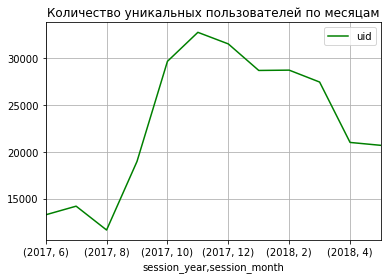

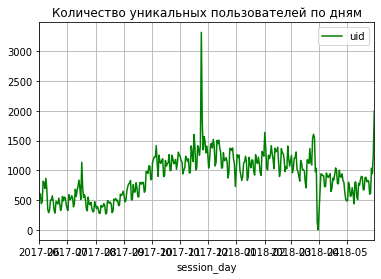

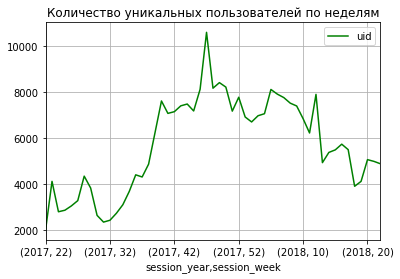

In [15]:
mau.plot(title = 'Количество уникальных пользователей по месяцам', grid = True, legend = True, color = 'g')

dau.plot(title = 'Количество уникальных пользователей по дням', grid = True, legend = True, color = 'g')

wau.plot(title = 'Количество уникальных пользователей по неделям', grid = True, legend = True, color = 'g')


Вывод:
1. В среднем в день приходит 907 новых пользователей;
2. Высокая активность фиксируется именно в конце года, что соответствует времени активной подготовки к препровозждению новогодних каникул.

###  Ежедневное посещение

In [16]:
#определеим, сколько раз за день пользователи заходят на сайт
daily_activity = visits.groupby('session_day').agg({'uid': ['count', 'nunique']})
daily_activity
daily_activity.columns = ['quantity_session', 'quantity_users']
daily_activity['daily_visits'] = daily_activity['quantity_session'] / daily_activity['quantity_users']

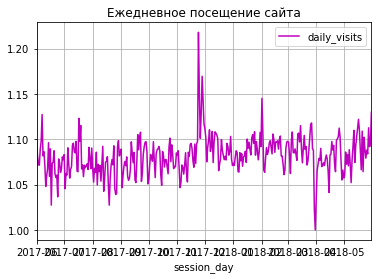

In [17]:
daily_activity['daily_visits'].plot(title = 'Ежедневное посещение сайта', grid = True, legend = True, color = 'm')           

Вывод:
Большинство пользователей ограничиваются одним заходом на сайт в течение дня. Чуть выше активность также наблюдается в период планирования новогодних выходных.

###  Продолжительность сессий пользователей

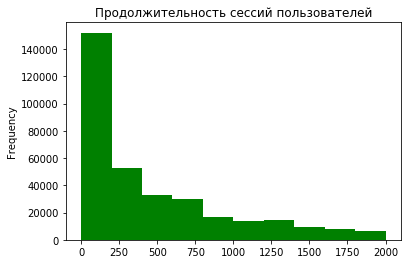

In [18]:
#изучим продолжительность сессий пользователей(рассчитаем ASL)
visits['session_duration'] = (visits['end ts'] - visits['start ts']).dt.seconds
visits['session_duration'].plot(kind = 'hist',range=(0,2000), title = 'Продолжительность сессий пользователей', color = 'g')
#plt.xlabel('Длительность сессии')
#plt.ylabel('Количество пользователей')

Вывод:
Наименьшая длительность сессии фиксируется у большинства пользователей, что свидетельствует о том, что людей не привлекает данный формат сайт или они не ходят нужную информацию за короткий срок.

Так как распределение не похоже на нормальное, то для расчета среднего значения рассчитаем часто повторяющееся значение

In [19]:
visits['session_duration'].describe()

count    359400.000000
mean        643.506489
std        1016.334786
min           0.000000
25%         120.000000
50%         300.000000
75%         840.000000
max       84480.000000
Name: session_duration, dtype: float64

In [20]:
visits['session_duration'].mode()

0    60
dtype: int64

In [21]:
visits['session_duration'].median()

300.0

###  Retention rate

In [22]:
#Находим даты первого визита клиентов
first_activity_date = visits.groupby('uid')['start ts'].min().reset_index()
first_activity_date.name = 'first_activity_date'
first_activity_date.columns = ['uid', 'first_visit']

In [23]:
#Соединяем визиты и даты первых визитов в одну таблицу
visits_new = first_activity_date.merge(visits)

In [24]:
#Переводим даты во временной формат с выделением месяца
visits_new['start ts'] = visits_new['start ts'].astype('datetime64[M]')
visits_new['first_visit'] = visits_new['first_visit'].astype('datetime64[M]')

In [25]:
#Находим показатель длительности использования клиентом приложения
visits_new['lifetime'] = (visits_new['start ts'] - visits_new['first_visit']) / np.timedelta64(1, 'M')
visits_new['lifetime'] = visits_new['lifetime'].round().astype('int')
visits_new.head()

uid first_visit   device              end ts  source id  \
0   11863502262781  2018-03-01    touch 2018-03-01 17:33:00          3   
1   49537067089222  2018-02-01    touch 2018-02-06 15:57:00          2   
2  297729379853735  2017-06-01  desktop 2017-06-07 18:48:00          3   
3  313578113262317  2017-09-01  desktop 2018-03-11 17:29:00          2   
4  313578113262317  2017-09-01  desktop 2017-09-18 23:07:00          2   

    start ts  session_year  session_month  session_week session_day  \
0 2018-03-01          2018              3             9  2018-03-01   
1 2018-02-01          2018              2             6  2018-02-06   
2 2017-06-01          2017              6            23  2017-06-07   
3 2018-03-01          2018              3            10  2018-03-11   
4 2017-09-01          2017              9            38  2017-09-18   

   session_duration  lifetime  
0               360         0  
1               120         0  
2                60         0  
3               360         6  
4              1080         0

In [26]:
#Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»
cohorts = visits_new.groupby(['first_visit', 'lifetime']).agg({'uid': 'nunique'}).reset_index()

In [27]:
#Найдём исходное количество пользователей в когорте, т.е. сколько пользователей было на 0 цикле жизни
initial_cohort_users = cohorts[cohorts['lifetime'] == 0][['uid', 'first_visit']]
initial_cohort_users.columns = ['initial_users', 'first_visit']

In [28]:
#Объединяем таблицы + рассчитываем retention rate
cohorts = cohorts.merge(initial_cohort_users)
cohorts['retention_rate'] = cohorts['uid'] / cohorts['initial_users']

In [29]:
retention_rate_pivot_table = cohorts.pivot_table(index = 'first_visit', columns = 'lifetime', values = 'retention_rate', aggfunc = 'sum') 

Text(0.5, 1, 'Retention rate')

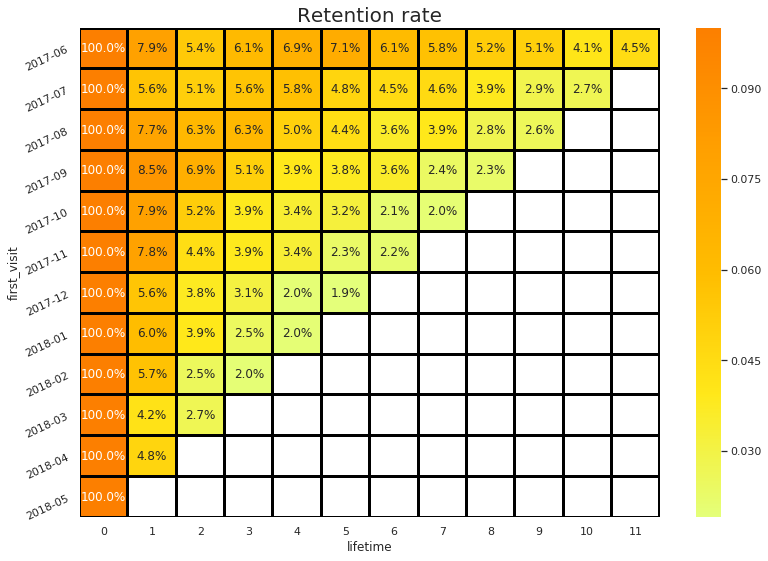

In [30]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(retention_rate_pivot_table, annot=True, fmt='.1%', linewidths=2, linecolor='black', cmap = 'Wistia', vmax = 0.1, yticklabels=retention_rate_pivot_table.index.strftime('%Y-%m'))
plt.yticks(rotation=25)
plt.title('Retention rate', fontsize=20)

Вывод:
основная масса клиентов уходят сразу же. Коэффициент удержания падает практически на 90-95% уже к 1 циклу жизни

Основные выводы по продуктовым метрикам:
1. Самая высокое значение показателя новых посетителей фиксируется в конце 2017 года(свыше 30000 за месяц); вероятнее всего связано с поиском развлекательных мероприятий на зиминие праздничные выходные;
2. В большинстве за день люди посещяют сайт не более одного раза; 
3. Длительность посещения сайта кратковременна: в среднем посетители проводят 10 минут на сайте, однако, учитывая скошенность распределения вправо, будет рассматривать наиболее повторяющееся значение - 1 минута; слишком быстрые сеансы!;
4. Обнаружена большая проблема с удержанием клиентов: основная масса пользователей (практически 90-95%) не возвращаются в приложение после первого использования (по всем когортам видим сильное снижение уже на следующий месяц);
5. Основной вывод по данным метрикам - отсутствие удовлетворенности сайтом клиентом: возможно, есть проблема с организованностью сайта(клиенту тяжело найти необходимую информацию и он быстро ищет альтернативный сайт, на это же и указывает низкое количество повторных посещений).

## Расчет метрик электронной коммерции

###  Длительность активности на сайте до первой покупки

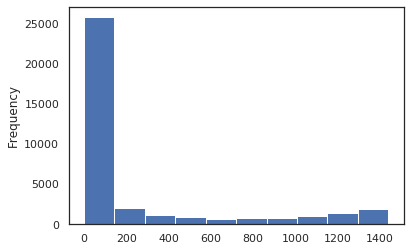

In [31]:
#рассчитываем длительность посещения сайта до первой покупки пользователя в минутах
orders_first = orders.groupby('uid').agg({'buy ts': 'min'}).reset_index()
orders_first.columns = ['uid', 'first_purchase']
purchases = first_activity_date.merge(orders_first)
purchases['duration_activity'] = (purchases['first_purchase'] - purchases['first_visit']).dt.seconds / 60 
purchases['duration_activity'].plot(kind = 'hist')

In [32]:
purchases['duration_activity'].median()

16.0

Вывод:
распределение далеко от нормального и мы видим много значений около X оси, поэтому для получения среднего значения будем рассматривать медианное значение.

###  Количество покупок на одного пользователя

In [33]:
orders_first['first_purchase'] = orders_first['first_purchase'].astype('datetime64[M]')
order_total = orders.merge(orders_first)
order_total['order_month'] = order_total['buy ts'].astype('datetime64[M]')

order_total['age'] = ((order_total['order_month'] - order_total['first_purchase'])/ np.timedelta64(1, 'M')).round().astype('int')
order_total_group = order_total.groupby(['first_purchase', 'age']).agg({'uid':['nunique', 'count']}).reset_index()
order_total_group.columns = ['first_order_month', 'age', 'n_users', 'n_purchase']
    
initial_users = order_total_group[order_total_group['age'] == 0][['first_order_month', 'n_users']]
initial_users.columns = ['first_order_month', 'initial_users']
order_total_group = order_total_group.merge(initial_users)
order_total_group['orders_per_user'] = order_total_group['n_purchase'] / order_total_group['initial_users']
orders_per_users_6month1 = order_total_group.query('age <= 5')
#order_total = order_total_group.pivot_table(index = 'first_order_month',columns = 'age', values = 'n_purchase', aggfunc = 'mean').round(2)


In [34]:
orders_per_users_6month2 = orders_per_users_6month1.groupby(['first_order_month', 'age']).agg({'n_purchase':'sum', 'initial_users':'mean'})
orders_per_users_6month2['purch_per_user'] = orders_per_users_6month2['n_purchase'] / orders_per_users_6month2['initial_users']
orders_per_users_6month2 = orders_per_users_6month2.pivot_table(index = 'first_order_month',columns = 'age', values = 'purch_per_user', aggfunc = 'mean').round(2)

Text(0.5, 1, 'Количество покупок на одного пользователя по когортам')

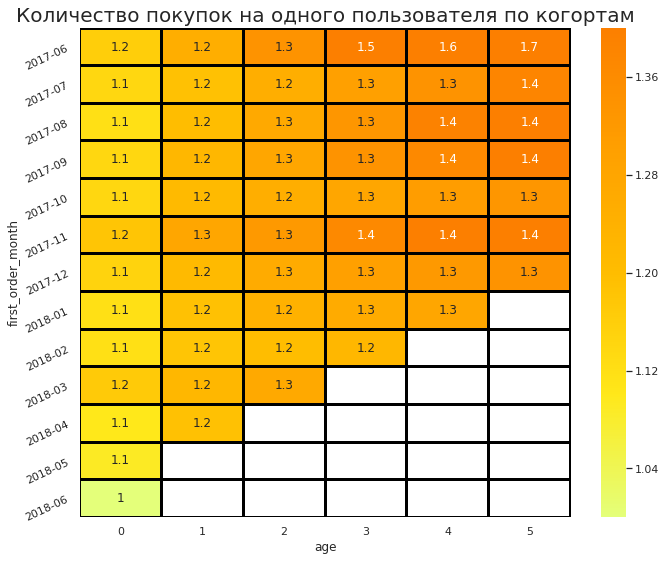

In [35]:
sns.set(style='white')
plt.figure(figsize=(11, 9))
sns.heatmap(orders_per_users_6month2.cumsum(axis = 1), annot=True, linewidths=2, linecolor='black', cmap = 'Wistia', vmax = 1.4, yticklabels=orders_per_users_6month2.index.strftime('%Y-%m') )
plt.yticks(rotation=25)
plt.title('Количество покупок на одного пользователя по когортам', fontsize=20)

Вывод:
в среднем каждый клиент совершает не более одной покупки за весь период пользования приложением. Стоит и тут отметить, что основная масса пользователей совершает покупки в первый визит. В последующие периоды покупки сильно падают.

###  Средний чек клиента

In [36]:
first_orders = orders.groupby('uid').agg({'buy ts': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_purchase']
first_orders_new_2 = first_orders.merge(orders)
first_orders_new_2['order_month']= first_orders_new_2['buy ts'].astype('datetime64[M]')
first_orders_new_2['first_purchase'] = first_orders_new_2['first_purchase'].astype('datetime64[M]')
first_orders_new_2_pivot = first_orders_new_2.pivot_table(index = 'first_purchase', columns = 'order_month', values = 'buy ts', aggfunc = 'count')


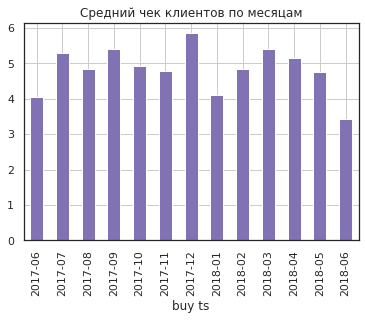

In [38]:
#Рассчитываем средний чек клиентов
first_orders_new_2['buy ts'] = first_orders_new_2['buy ts'].astype('datetime64[M]')
average_check = first_orders_new_2.groupby('buy ts').agg({'uid': 'count', 'revenue': 'sum'}).reset_index()
average_check.columns = ['buy ts','n_purchases', 'revenue_total']
average_check['check_value'] = average_check['revenue_total'] / average_check['n_purchases']
average_check['buy ts'] = average_check['buy ts'].dt.strftime('%Y-%m')
average_check = average_check.groupby('buy ts').agg({'check_value':'mean'})
average_check['check_value'].plot(kind = 'bar', title ='Cредний чек клиентов по месяцам', grid = True, color = 'm')
plt.yticks(rotation='horizontal');
#plt.xlabel('Месяца')
#plt.ylabel('Средний чек')


Вывод:
Также как и с количеством покупок возрастает и средний чек при приближении новогодних праздников

###  Расчет  LTV

In [39]:
orders['order_month'] = orders['buy ts'].astype('datetime64[M]')
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
#первый месяц покупки
orders_min_date = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
orders_min_date.columns = ['uid', 'first_order_month']
#количество новых пользователей за каждый месяц
new_users = orders_min_date.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
new_users.columns = ['first_order_month', 'new_user']
orders_new = orders.merge(orders_min_date)
#группировка таблицы по месяцу заказа и первому месяца заказа
cohorts_orders = orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue':'sum'}).reset_index()
cohorts_orders
#теперь добавляем сюда таблицу с количеством новых пользователей
pivot = cohorts_orders.merge(new_users)
#рассчитываем возраст когорты
pivot['age'] = ((pivot['order_month'] - pivot['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
#теперь рассчитаем ltv(т.к. маржинальность равна 100%, то берем выручку (revenue))
pivot['ltv'] = pivot['revenue'] / pivot['new_user']
#сделаем срез для 6 месяцев
pivot_1 = pivot.query('age <= 5')
#сделаем группировку для отображения ltv
pivot_total = pivot_1.pivot_table(index = 'first_order_month', columns = 'age', values = 'ltv', aggfunc = 'mean')
pivot_total_new = pivot_total.round(2).cumsum(axis=1)

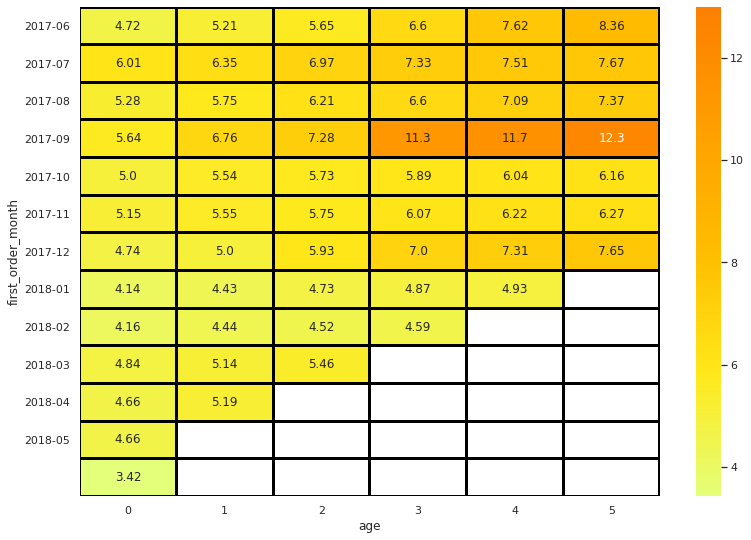

In [40]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
sns.heatmap(pivot_total_new, annot=True, fmt='.3', linewidths=2, linecolor='black',\
            cmap = 'Wistia', vmax = 13, yticklabels=retention_rate_pivot_table.index.strftime('%Y-%m'));

In [41]:
#накопительный LTV за 6 месяцев
pivot_total_1 = pivot_total.cumsum(axis=1).mean(axis=0)[5]
pivot_total_1

7.969052630207336

Вывод:
в среднем за пол года пользователь приносит практически 8 д.е. компании. 

Основные выводы по метрикам электронной коммерции:
1. В среднем до первой покупки посетители проводят на сайте около 60 секунд, что уже может свидетельствовать о том, что большинство пользователей из представленной выборки заранее знают, что хотя приобрести на сайте, именно поэтому им необходимо минимальное количество времени;
2. В среднем за полгода клиент совершает 15 покупок, достаточно хороший показатель!;
3. Средний чек обычно колеблется около 5-7 д.е., однако здесь снова фиксируем повышение на 12 месяце, что равносильно заказам на новогодние праздники, где чек около 14 д.е.; также отмечаем значительное повышение среднего чека в осенний период, вероятнее всего ввиду ухудшения погодных условий и желанию приятного препровождения на развлекательных мероприятиях;
4. Показатель ltv (т.е. количество денежных средств, которое приносят пользователи за пол года) равен 7.9 , соответственно затраты на меркетинг на одного клиента не должны превышать данную цифру для того, чтобы маркетинг был выгоден компании;

## Расчет маркетинговых метрик

###   Сумма расходов / расходы по источникам

In [42]:
#суммарные расходы на маркетинг
costs_sum_total = costs['costs'].sum()
costs_sum_total

329131.62

In [43]:
#распределение затрат по источника
source_costs = costs.groupby('source_id').agg({'costs': 'sum'}).reset_index()
from plotly import graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values= source_costs['costs'] ,sort = False,\
                     labels = source_costs['source_id'], title = 'Распределение затрат по источникам'))
fig.show()


In [44]:
#распределение затрат по дате
costs['dt'] = costs['dt'].astype('datetime64')
costs['month_costs'] = costs['dt'].dt.month
time_costs = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()
time_costs.pivot = costs.pivot_table(index = 'costs_month', columns = 'source_id', values = 'costs', aggfunc = 'sum')
time_costs.pivot

source_id         1        2         3        4        5       9       10
costs_month                                                              
2017-06-01   1125.61  2427.38   7731.65  3514.80  2616.12  285.22  314.22
2017-07-01   1072.88  2333.11   7674.37  3529.73  2998.14  302.54  329.82
2017-08-01    951.81  1811.05   6143.54  3217.36  2185.28  248.93  232.57
2017-09-01   1502.01  2985.66   9963.55  5192.26  3849.14  415.62  460.67
2017-10-01   2315.75  4845.00  15737.24  6420.84  5767.40  609.41  627.24
2017-11-01   2445.16  5247.68  17025.34  5388.82  6325.34  683.18  792.36
2017-12-01   2341.20  4897.80  16219.52  7680.47  5872.52  657.98  645.86
2018-01-01   2186.18  4157.74  14808.78  5832.79  5371.52  547.16  614.35
2018-02-01   2204.48  4474.34  14228.56  5711.96  5071.31  551.50  480.88
2018-03-01   1893.09  3943.14  13080.85  5961.87  4529.62  480.29  526.41
2018-04-01   1327.49  2993.70   9296.81  4408.49  3501.15  373.49  388.25
2018-05-01   1467.61  2689.44   9411.42  4214.21  3669.56  362.17  409.86

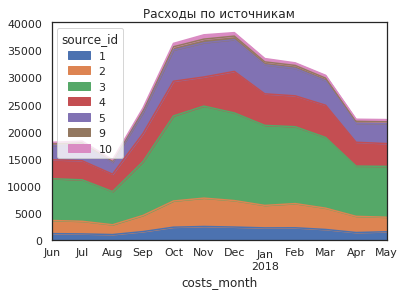

In [46]:
time_costs.pivot.plot.area(title = 'Расходы по источникам');

Вывод:
самым затратным источником является - источник номер 3, самым дешевым для компании - источник 10. Здесь будет любопытно посмотреть, сколько новых клиентов привлекает каждый источник, а также окупаемость каждого из источников. 

###  Расчет CAC

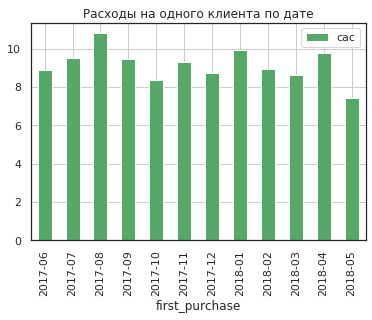

In [48]:
costs_new1 = costs.groupby('costs_month').agg({'costs':'sum'}).reset_index()
first_orders_new_3 = first_orders_new_2.groupby('first_purchase').agg({'uid':'nunique'}).reset_index()
first_orders_new_3 = first_orders_new_3.merge(costs_new1, left_on = 'first_purchase', right_on = 'costs_month')
first_orders_new_3['cac'] = first_orders_new_3['costs'] / first_orders_new_3['uid']
first_orders_new_3['first_purchase'] = first_orders_new_3['first_purchase'].dt.strftime('%Y-%m')
cac_report = first_orders_new_3.pivot_table(index = 'first_purchase', values = 'cac', aggfunc = 'mean')
cac_report.plot(kind = 'bar',title ='Расходы на одного клиента по дате', grid = True, color = 'g')
plt.yticks(rotation='horizontal');

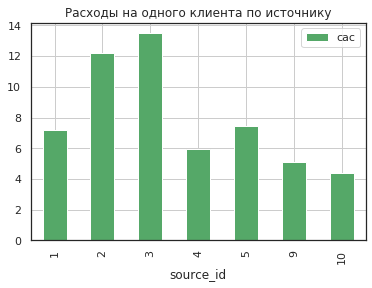

In [50]:
#ищем первый источник захода посетителя
first_source_new = visits.sort_values(by = ['uid', 'start ts']).groupby('uid').agg({'source id': 'first', 'session_month': 'first'}).reset_index()
first_source_new.columns = ['uid', 'first_source', 'session_month']
#группируем по уникальному номеру
orders1 = orders.merge(first_source_new, on ='uid')
#ищем кол-во уникальных клиентов по источникам 
source_users = orders1.groupby('first_source').agg({'uid':'nunique'}).reset_index()
source_users.columns = ['source_id', 'n_users_by_source']
#соединяем
cac_by_source = source_costs.merge(source_users)
cac_by_source['cac'] = cac_by_source['costs'] / cac_by_source['n_users_by_source']
cac_by_source_pivot = cac_by_source.pivot_table(index = 'source_id', values = 'cac', aggfunc = 'mean')
cac_by_source_pivot.plot(kind = 'bar',title ='Расходы на одного клиента по источнику', grid = True, color = 'g');

In [51]:
cac_report['cac'].median()

9.12581426168029

In [52]:
main_source = visits.groupby(['uid']).agg({'start ts':'min', 'source id' : 'first'}).reset_index()
main_source = main_source[['uid', 'source id']]

In [53]:
orders2 = orders.merge(main_source, on='uid', how='left')
orders2 = orders2.dropna()
orders2['source id'] = orders2['source id'].astype(int)
cohorts_by_source = (orders2.groupby(['order_month', 'source id']).agg({'uid': 'nunique','revenue':'sum'}).reset_index())

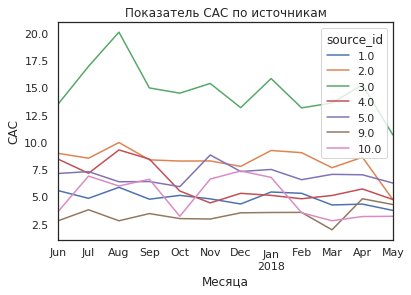

In [55]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
month_costs = costs.groupby(['costs_month', 'source_id'])['costs'].sum().reset_index()
report = cohorts_by_source.merge(month_costs,left_on=['order_month','source id'],right_on=['costs_month', 'source_id'], how='outer')
report = report[['order_month','source_id', 'uid','revenue','costs']].rename(columns={'uid': 'cohort_users', 'order_month':'cohort'})

report['cac'] = (report['costs']/report['cohort_users']).round(2)
cac = report.pivot_table(index='cohort', columns='source_id', values='cac', aggfunc='mean')
cac.plot(title = 'Показатель CAC по источникам', legend = True)
plt.xlabel('Месяца')
plt.ylabel('CAC');

Вывод:
Самым затратным у нас выходит 3 источник, а минимум затрат приходится на 10 источник, однако нужно посмотреть именно показатель окупаемости наших инвестиций в маркетинг, чтобы лучше оценить обстановку. Если мы будем смотреть на расходы по месяцам, то сильной закономерности тут сложно выявить: видим определенную цикличность, что приблизительно раз в 4 месяца отдел маркетинга увеличивает расходы на клиентов, но с чем это связано сложно предугадать.

###  Расчет ROMI

In [56]:
order_first = orders.groupby('uid').agg({'order_month': 'min'}).reset_index()
order_first.columns = ['uid', 'first_order_month']
orders_new = order_first.merge(orders1)
#объединяем визиты с покупками
order_visit_new = visits_new.merge(orders_new, on ='uid')

#группируем по месяцу первого захода и источнику и найдем число уникальных пользователе
uniq_users = order_visit_new.groupby(['first_order_month', 'first_source']).agg({'uid':'nunique'}).reset_index()
uniq_users.columns = ['first_order_month', 'first_source', 'uniq_users']
#объединяем уникальных пользователей с первоначальной таблицей
orders_visits_uniq_users = uniq_users.merge(order_visit_new, on = ['first_order_month', 'first_source'])
orders_visits_uniq_users['age'] = ((orders_visits_uniq_users['order_month'] - orders_visits_uniq_users['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')
#считаем доход покупателя
data = orders_visits_uniq_users.groupby(['first_order_month', 'age', 'first_source']).agg({'revenue':'sum', 'uniq_users':'mean'}).reset_index()
data['rev_per_user'] = data['revenue'] / data['uniq_users']


In [57]:
#формируем затраты
costs_for_romi = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_for_romi.columns = ['first_order_month', 'source', 'costs']
#группируем
revenue_costs = data.merge(costs_for_romi, left_on = ['first_order_month', 'first_source'], right_on = ['first_order_month', 'source'], how = 'left')

revenue_costs['costs_per_user'] = revenue_costs['costs'] / revenue_costs['uniq_users']
revenue_costs['romi'] = revenue_costs['rev_per_user'] / revenue_costs['costs_per_user']
romi_pivot = revenue_costs.pivot_table(index = 'first_source', columns = 'age', values = 'romi').round(1).cumsum(axis =1)

In [58]:
romi_cohorts_pivot = revenue_costs.pivot_table(index = 'first_order_month', columns = 'first_source', values = 'romi').round(1).cumsum(axis =1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



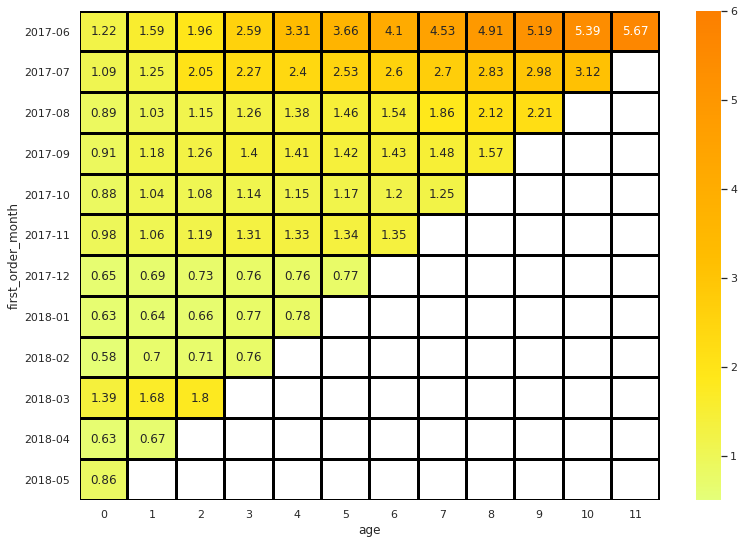

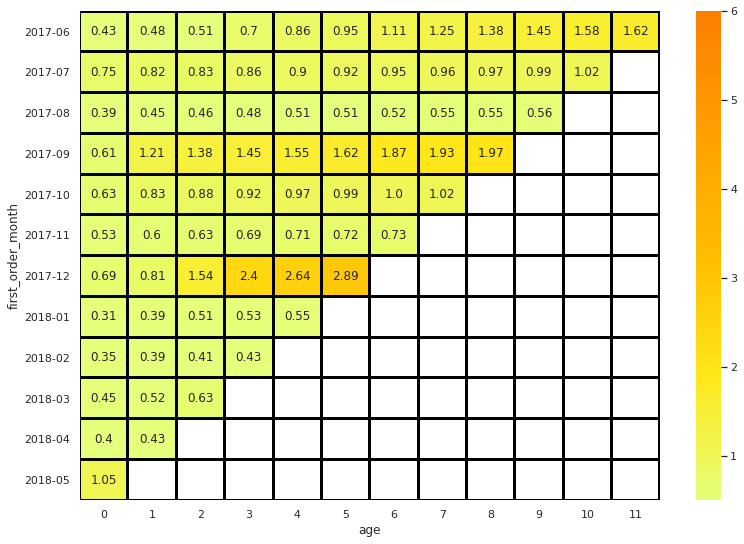

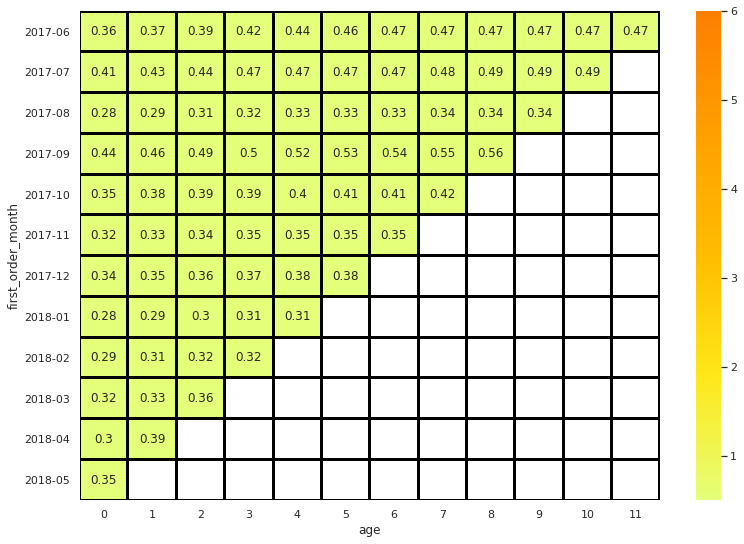

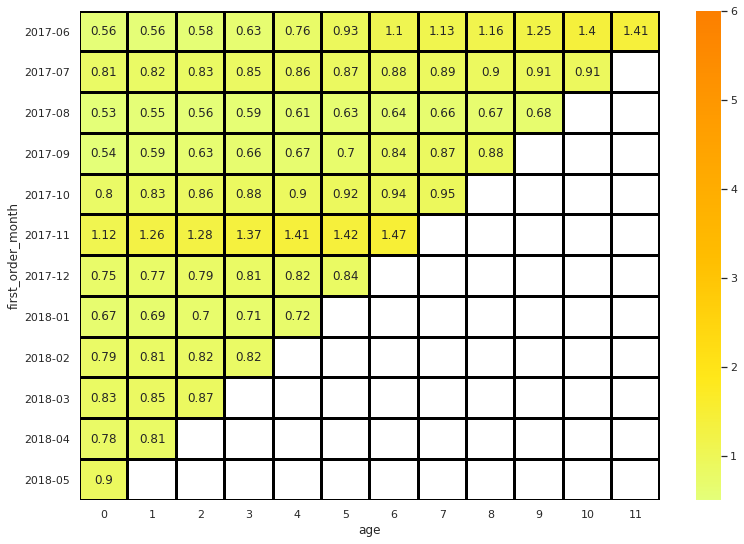

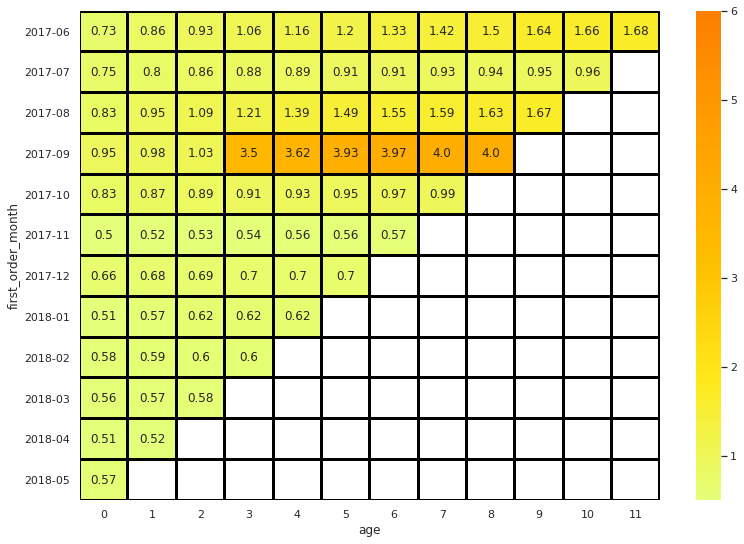

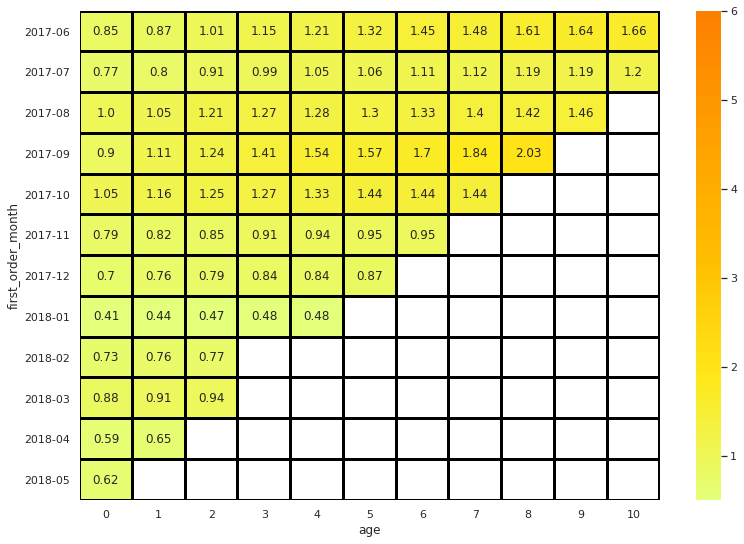

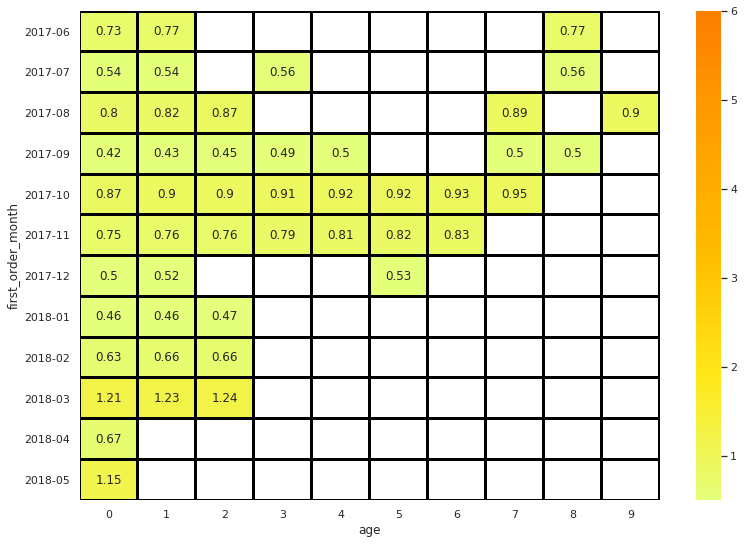

In [60]:
# определяем источник получения пользователей
users = visits.sort_values(by=['uid', 'start ts']).groupby('uid').agg({'source id':'first'}).reset_index()
users.columns = ['uid', 'source_id']
#начинаем цикл
source = [1, 2, 3, 4, 5, 9, 10]
for x in source:
    source_users = users.query('source_id == @x')['uid']
    orders_ltv = orders.query('uid in @source_users')
    costs_ltv = costs.query('source_id == @x')
    orders_ltv['order_month'] = orders_ltv['buy ts'].astype('datetime64[M]')
    costs_ltv['month'] = costs_ltv['dt'].astype('datetime64[M]')
    first_orders = orders_ltv.groupby('uid').agg({'order_month': 'min'}).reset_index()
    first_orders.columns = ['uid', 'first_order_month']
#считаем кол-во пользователей в первый месяц
    cohort_sizes = (first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index())
    cohort_sizes.columns = ['first_order_month', 'n_buyers']
#соединяем столбцы
    orders_new = pd.merge(orders_ltv, first_orders, on='uid')
#считаем прибыль по когортам
    cohorts = (orders_new.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum'}).reset_index())
#соединяем 
    report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
#ищем возраст по когортам 
    margin_rate = 1
    report['gp'] = report['revenue'] * margin_rate
    report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
    report['age'] = report['age'].round().astype('int')
#находим прибыль на пользователя
    report['ltv'] = report['gp'] / report['n_buyers']
#считаем cac 
    costs_romi = costs_ltv.groupby('costs_month').agg({'costs':'sum'}).reset_index()
    data = report.merge(costs_romi, left_on = 'first_order_month', right_on = 'costs_month')
    data['cac'] = data['costs'] / data['n_buyers']
    cac_report = data.pivot_table(index = 'first_order_month', values = 'cac', aggfunc = 'mean')
#объединяем cac и ltv
    data['romi'] = data['ltv'] / data['cac']
    romi_pivot = (data.pivot_table(index = 'first_order_month', columns = 'age', values = 'romi', aggfunc = 'mean')).round(2).cumsum(axis =1)
    sns.set(style='white')
    #plt.title('Показатель romi по @x источнику')
    plt.figure(figsize=(13, 9))
    sns.heatmap(romi_pivot, annot=True, linewidths=2,fmt='.3', linecolor='black', cmap = 'Wistia', vmax = 6, vmin = 0.5, yticklabels=romi_pivot.index.strftime('%Y-%m'));

Вывод: показатель romi свидетельствует о том, что по окупаемости лучше всего 1, 2 и 5 источники. 2 и 5 источники приблизительно одинаковы, а 1 источник очевидно лидирует. По когортам: наилучшие показатели демонстрируются июньская когорта, сентябрьская когорта и мартовская.
    

Выводы по маркетинговым метрикам:
1. Суммарные расходы за изучаемый период составляют - 329131.62; самым затратным является третий источник; самые низкие показатели вложения средств у 9 источника;
2. Как и предполагалось исходя из исследований активности пользователей затвраты на маркетинг выше в ноябре-декабре, т.е. соответствуют датам высокой активности клиентов;
3. Самые большие вложения делаются в третий источник, в то время как основной поток клиентов приходит с 4 источника;
4. Как указывалось ранее основные вклады делаются в 3 источник, в то же время его окупаемость сильно страдает; в соотношении затраты - прибыль наилучшим источником является - 1( его окупаемость чуть больше 100%, т.е. затраты на него польностью окупились и + мы получили еще прибыль с этого источника);к сожалению, остальные источники даже не выходят в 0 по окупаемости;
5. Если мы будем смотреть окупаемость затрат в разрезе когорт, то увидим, что ни одна из когорт не окупилась по маркетинговым затратам.

## Выводы и рекомендации

### Источники трафика

Несмотря на то, что маркетологи активно вкладывают в 3 источник, нам лучше не делать на него сильный упор, поскольку его окупаемость слишком низкая. Стоит более детально проанализировать 1 источник, поскольку он окупается и приносит прибыль. 

In [61]:
revenue_costs
from plotly import graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values= revenue_costs['costs'] ,sort = False, labels = revenue_costs['first_source'], title = 'Распределение затрат по источникам'))
fig.show()

In [62]:
from plotly import graph_objects as go
fig = go.Figure()
fig.add_trace(go.Pie(values= revenue_costs['revenue'] ,sort = False, labels = revenue_costs['first_source'], title = 'Распределение дохода по источникам'))
fig.show()

### Метрики

На основе данной выборке по изученным метрикам мы можем выявить следующее:
1. Длительность посещения сайта имеет низкие показатели: большинство клиентов проводят в среднем **1 минуту на сайте**, но в тоже время метрики говорят о том, что клиенты часто совершают покупку уже через 60 секунд;
2. Коэффициент удержания упорно говорит о том, что **сайт " не цепляет" клиентов**, и они зачастую не возвращаются на сайт совсем;
3. Затраты на маркетинг в расчете на одного клиента **не должны превышать 7.9 д.е.**, чтобы проведение маркетинговых мероприятий было выгодно компании; в то время как на данный момент **расходы составляют 9.1 д.е.!!**;
4. Средний чек клиентов колеблется от 4 до 6 д.е., но его стоимость возврастает под конец года, как впрочем и основная активность аудитории;
5. Еще раз стоит акцентировать внимание на необходимости **снижения затрат на 3 источник и вложение основных средств в 1 и 5 источники**; по коэффициенту romi 2 источник также дает хорошие результаты, но все таки так достаточно высокие затраты.

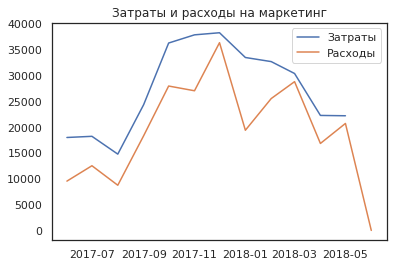

In [63]:
costs__for_compare = costs.groupby('costs_month').agg({'costs':'sum'})
orders_for_compare = orders.groupby('order_month').agg({'revenue':'sum'})
plt. plot(costs__for_compare['costs'], label = 'Затраты')
plt. plot(orders_for_compare['revenue'], label = 'Расходы')
plt.legend()
plt.title('Затраты и расходы на маркетинг');

### Когорты

Сравнительно хороший коэффициент удержания мы можем заметить в когорте 2017-июнь; также коэффициент окупаемости затрат в среднем для данной когорты выше чем для всех остальных, однако неплохие результаты по окупаемости затрат демонстрируют также сентябрьская и мартовская когорты. Таким образом, основной упор при планировании маркетинговых мероприятий стоит делать на июньские, сентябрьские и мартовские когорты.
